In [1]:
import pandas as pd
import lightgbm as lgb
from datetime import datetime
import matplotlib.pyplot as plt
import json
import numpy as np

import warnings
warnings.filterwarnings('ignore')

fase = '05_lightgbm (un intento)'

In [2]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [3]:
folder = gen_config['folder']

path_pred_test = gen_config['path_pred_test']
path_pred_futuro = gen_config['path_pred_futuro']
path_prod_stats = gen_config['path_prod_stats']

path_train = gen_config['path_train']
path_test = gen_config['path_test']
path_futuro = gen_config['path_futuro']

lgbm_params = gen_config['var_lgbm_params']
exclusiones = gen_config['var_exclusiones']
dibujar_pesos = gen_config['var_dibujar_pesos']
var_num_boost_round = gen_config['var_num_boost_round']

print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
--------------------------------------05_lightgbm (un intento)--------------------------------------


In [4]:
df_train = pd.read_parquet(f"{folder}/{path_train}")
df_test = pd.read_parquet(f"{folder}/{path_test}")
df_futuro = pd.read_parquet(f"{folder}/{path_futuro}")

print(f"{'Shape df_train':.<25}: {df_train.shape}")
print(f"{'Shape df_test':.<25}: {df_test.shape}")
print(f"{'Shape df_futuro':.<25}: {df_futuro.shape}")

Shape df_train...........: (2173865, 155)
Shape df_test............: (68823, 155)
Shape df_futuro..........: (53008, 155)


In [5]:
categorical_features = df_train.select_dtypes(['category']).columns.tolist()
for col in categorical_features:
    df_train[col] = df_train[col].cat.codes
    df_test[col] = df_test[col].cat.codes
    df_futuro[col] = df_futuro[col].cat.codes
print(f"Convertidas a categorical: {categorical_features}")

Convertidas a categorical: ['yearquarter', 'cat1', 'cat2', 'cat3', 'brand', 'descripcion']


In [6]:
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
X_futuro = df_futuro.iloc[:,:-1]

y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]
y_futuro = df_futuro.iloc[:,-1]

print(f"{'Shape X_train':.<25}: {X_train.shape}")
print(f"{'Shape X_test':.<25}: {X_test.shape}")
print(f"{'Shape X_futuro':.<25}: {X_futuro.shape}")

print(f"{'Shape y_train':.<25}: {y_train.shape}")
print(f"{'Shape y_test':.<25}: {y_test.shape}")
print(f"{'Shape y_futuro':.<25}: {y_futuro.shape}")

Shape X_train............: (2173865, 154)
Shape X_test.............: (68823, 154)
Shape X_futuro...........: (53008, 154)
Shape y_train............: (2173865,)
Shape y_test.............: (68823,)
Shape y_futuro...........: (53008,)


In [8]:
train_data = lgb.Dataset(X_train.drop(columns=exclusiones), label=y_train)
test_data = lgb.Dataset(X_test.drop(columns=exclusiones), label=y_test)
futuro_data = lgb.Dataset(X_futuro.drop(columns=exclusiones), label=y_futuro)

params = lgbm_params

model = lgb.train(params,
                train_data,
                num_boost_round=var_num_boost_round,
                valid_sets=[train_data, test_data],
                )

#y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = model.predict(X_test.drop(columns=exclusiones), num_iteration=model.best_iteration)
y_pred_futuro = model.predict(X_futuro.drop(columns=exclusiones), num_iteration=model.best_iteration)

#example_row = X_test.iloc[0]
#example_pred = model.predict(example_row.values.reshape(1, -1), num_iteration=model.best_iteration)
#print(f'Prediction for example row: {example_pred[0]}')

[LightGBM] [Info] Total Bins 90394
[LightGBM] [Info] Number of data points in the train set: 2173865, number of used features: 152
[LightGBM] [Info] Start training from score -0.000213


In [9]:
final = X_test
final['tn_futuro'] = y_test
final['tn_prediccion'] = y_pred

In [10]:
#prod_stats = pd.read_parquet('prod_stats.parquet')
prod_stats = pd.read_parquet(f"{folder}/{path_prod_stats}")
#prod_stats = pd.read_parquet('./Experimentos/2024-06-23_NuevoScript/01_prod_stats.parquet')

prod_stats = prod_stats[['product_id','customer_id', 'average_tn', 'std_dev_tn']]
final = final.merge(prod_stats, how='left', on=['product_id','customer_id'])
final.columns

Index(['periodo', 'product_id', 'customer_id', 'primer_periodo',
       'ultimo_periodo', 'tn_norm', 'periodo_dt', 'mes', 'quarter',
       'month_in_quarter',
       ...
       'prop_product_yearquarter_brand',
       'prop_product_yearquarter_descripcion', 'prop_product_year_cat1',
       'prop_product_year_cat2', 'prop_product_year_brand',
       'prop_product_year_descripcion', 'tn_futuro', 'tn_prediccion',
       'average_tn', 'std_dev_tn'],
      dtype='object', length=158)

In [11]:
final['tn_futuro_real'] = (final['tn_norm'] + final['tn_futuro']) * final['std_dev_tn'] + final['average_tn'] # por dos porque esta normalizado y al hacer sumas y restas se acumulan medias
final['tn_prediccion_real'] = (final['tn_norm'] + final['tn_prediccion']) * final['std_dev_tn'] + final['average_tn']

In [12]:
final.head()

,periodo,product_id,customer_id,primer_periodo,ultimo_periodo,tn_norm,periodo_dt,mes,quarter,month_in_quarter,...,prop_product_year_cat1,prop_product_year_cat2,prop_product_year_brand,prop_product_year_descripcion,tn_futuro,tn_prediccion,average_tn,std_dev_tn,tn_futuro_real,tn_prediccion_real
0,201910,20001,10001,201701,201912,-0.002853,201910,10,4,1,...,0.886014,1.615233,4.856661,5.280223,-0.633228,-0.011160,176.332358,106.032781,108.886823,174.846428
1,201910,20001,10002,201701,201912,-0.682375,201910,10,4,1,...,0.119940,0.232762,2.219713,2.355310,1.644565,0.072234,39.873140,32.921912,71.550300,19.786154
2,201910,20001,10003,201701,201912,-0.636082,201910,10,4,1,...,0.640027,1.524578,3.846872,4.306583,0.511200,0.070922,118.936374,67.491501,110.507895,80.792907
3,201910,20001,10004,201701,201912,0.962191,201910,10,4,1,...,3.434900,5.606660,15.234681,15.614218,-0.413359,-0.145367,215.009476,114.272811,277.726070,308.350176
4,201910,20001,10005,201701,201912,-0.124882,201910,10,4,1,...,0.191784,0.309645,7.100979,8.472211,1.109747,0.007888,18.928779,14.330075,33.041972,17.252251


In [13]:
#final.to_parquet('sell_in_pred.parquet', index=False)
final.to_parquet(f'{folder}/{path_pred_test}', index=False)

In [14]:
final_futuro = X_futuro
final_futuro['tn_futuro'] = y_futuro
final_futuro['tn_prediccion'] = y_pred_futuro

final_futuro = final_futuro.merge(prod_stats, how='left', on=['product_id','customer_id'])
final_futuro.columns

# por dos porque esta normalizado y al hacer sumas y restas se acumulan medias
final_futuro['tn_futuro_real'] = (final_futuro['tn_norm'] + final_futuro['tn_futuro']) * final_futuro['std_dev_tn'] + final_futuro['average_tn'] 
final_futuro['tn_prediccion_real'] = (final_futuro['tn_norm'] + final_futuro['tn_prediccion']) * final_futuro['std_dev_tn'] + final_futuro['average_tn']

#final_futuro.to_parquet('sell_in_pred_futuro.parquet', index=False)
final_futuro.to_parquet(f'{folder}/{path_pred_futuro}', index=False)

In [15]:
#estado_control = f"05_lightgbm Terminado - {nombrefile} - {datetime.now()}"

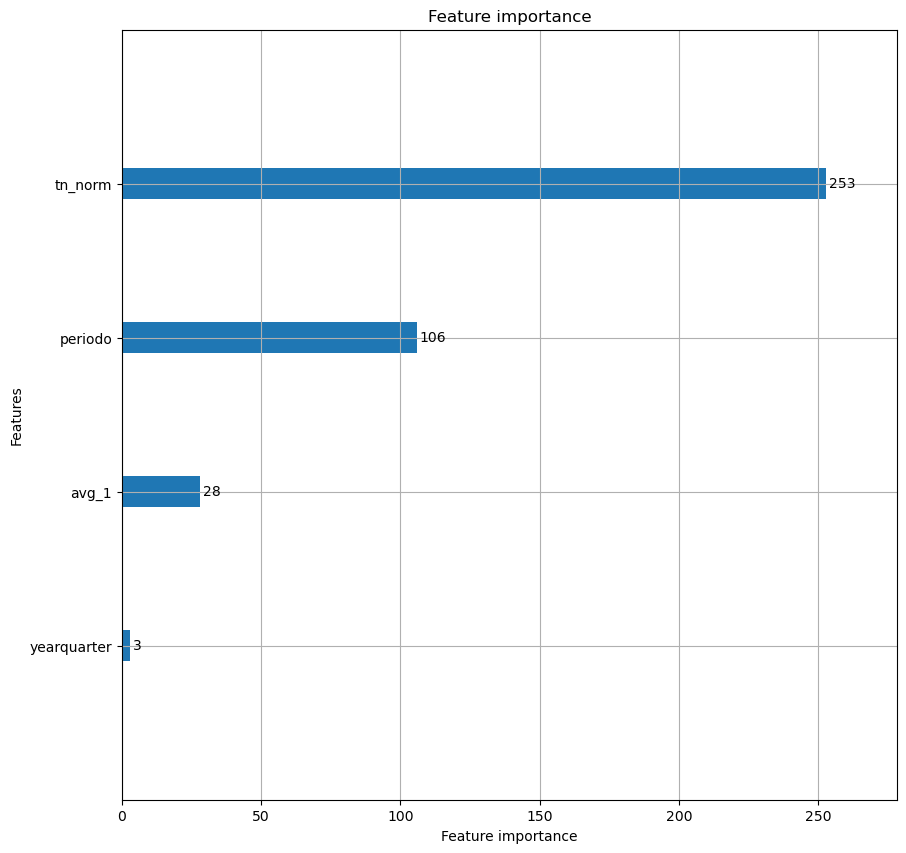

In [16]:
lgb.plot_importance(model, max_num_features=20, figsize=(10,10))
plt.show()

In [17]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance_gain': model.feature_importance(importance_type='gain'),
        'importance_split': model.feature_importance(importance_type='split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
importance_df.sort_values('importance_split', ascending=False, inplace=True)
feat_dibujar = importance_df[0:20]['feature_name'].reset_index(drop=True)

In [18]:
importance_df

,feature_name,importance_gain,importance_split
0,tn_norm,1.140616e+07,253
2,periodo,1.032519e+05,106
1,avg_1,1.087667e+06,28
3,yearquarter,6.502510e+03,3
97,avg_2,0.000000e+00,0
...,...,...,...
53,prop_product_yearquarter_brand,0.000000e+00,0
54,prop_product_yearquarter_descripcion,0.000000e+00,0
55,prop_product_year_cat1,0.000000e+00,0
56,prop_product_year_cat2,0.000000e+00,0


In [19]:
if dibujar_pesos==True:
    fig, axs = plt.subplots(5, 4, figsize=(20, 25))
    d = -1
    for i in range(4):
        for j in range(5):
            d+=1
            lgb.plot_split_value_histogram(model,
                            feature=feat_dibujar[d],
                            bins="auto",
                            ax=axs[j, i]
                            ,title=f"Feat: {feat_dibujar[d]}")
    plt.show()

In [20]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

--------------------------------------05_lightgbm (un intento)--------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



